### 各種設定

In [25]:
import os
import sys
import random
import math
import re
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image

from glob import glob
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

import warnings
warnings.simplefilter('ignore')

2023-11-05 20:08:49.900185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 20:08:49.900281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 20:08:49.902274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 20:08:50.101111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 20:08:51.528390: W tensorflow/compiler/

In [26]:
# 疑似乱数の固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### データの読み込み

In [3]:
# # データの読み込み
# PJT_ROOT = Path("/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice") # NOTE: ここは各自いじる必要あり
# DATA_DIR = PJT_ROOT.joinpath("data")
# X_train = np.load(DATA_DIR.joinpath("X_train.npy"))

# X_train[X_train==1] = 0 # 画素値の最小を1から0に変更
# y_train = np.load(DATA_DIR.joinpath("y_train.npy"))
# X_test = np.load(DATA_DIR.joinpath("X_test.npy"))
# sample_submission_df = pd.read_csv(DATA_DIR.joinpath("sample_submit.csv"))

In [4]:
# X_train.shape, y_train.shape, X_test.shape

In [27]:
# labelごとで一つのデータセットにつきデータの総数を14000にする
EACH_NUM_ONESET = 7500
for i in range(1, 5):
    dataset_dict_tmp = joblib.load(f'/mnt/g/マイドライブ/MyStudy/MySIGNATE/SonyDice/data/dataset_dict_adjust_10M_{i}.bin')
    imgs_oneset = dataset_dict_tmp['images']
    labels_oneset = dataset_dict_tmp['labels']

    for j in range(1, 19):
        flag = labels_oneset == j
        imgs_tmp = imgs_oneset[flag][:EACH_NUM_ONESET]
        labels_tmp = labels_oneset[flag][:EACH_NUM_ONESET]

        if j == 1 and i == 1:
            imgs = imgs_tmp
            labels = labels_tmp
        else:
            imgs = np.vstack([imgs, imgs_tmp])
            labels = np.hstack([labels, labels_tmp])

print(imgs.shape, labels.shape)

(540000, 20, 20) (540000,)


### データの前処理

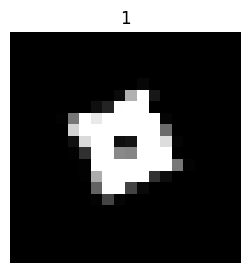

In [29]:
fig = plt.figure(figsize=(3, 3))
ax = plt.gca()
plt.imshow(imgs[999], cmap='gray')
plt.title(labels[999])
ax.axis('off')
plt.show()

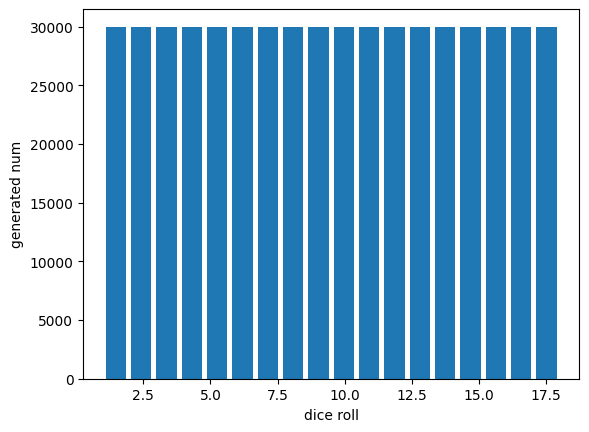

In [30]:
plt.hist(labels, bins=18, rwidth=0.8)
plt.xlabel('dice roll')
plt.ylabel('generated num')
plt.show()

In [31]:
# trainデータとvalデータの平均, 標準偏差を求める
trn_imgs, val_imgs, trn_labels, val_labels = train_test_split(imgs, labels, test_size=0.2, random_state=1, stratify=labels)

In [32]:
trn_imgs_tmp = trn_imgs.copy()
val_imgs_tmp = val_imgs.copy()

tmp_trans = transforms.ToTensor()
trn_imgs_t = tmp_trans(trn_imgs_tmp)
val_imgs_t = tmp_trans(val_imgs_tmp)

trn_mean = torch.mean(trn_imgs_t)
trn_std = torch.std(trn_imgs_t)

val_mean = torch.mean(val_imgs_t)
val_std = torch.std(val_imgs_t)

print(f'trn mean: {trn_mean}')
print(f'trn std: {trn_std}')
print(f'val mean: {val_mean}')
print(f'val std: {val_std}')

trn mean: 0.2525666654109955
trn std: 0.3987374007701874
val mean: 0.25250500440597534
val std: 0.39870861172676086


### データセット, データローダーの作成

In [38]:
# 要注意
BATCH_SIZE = 128

In [34]:
def trnTransfomer(img, label, data_type):
    assert data_type in ['trn', 'val']

    if data_type == 'trn':
        trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.2526), (0.3987))
        ])
    elif data_type == 'val':
        trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.2525), (0.3987))
        ])

    img_t = trans(img)
    label_t = torch.tensor(label-1, dtype=torch.long)

    return img_t, label_t

In [35]:
class TrainDataset(Dataset):
    '''学習用のデータセット

    args:
        imgs (ndarray): 画像データ shape=(N, 20, 20)
        labels (ndarray): ラベルデータ shape=(N, )
    '''
    def __init__(self, imgs, labels, data_type):
        self.imgs = imgs
        self.labels = labels
        self.data_type = data_type

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.imgs[idx, :]
        img = img.astype(np.uint8)

        label = self.labels[idx]

        img_t, label_t = trnTransfomer(img, label, self.data_type)

        return img_t, label_t

In [36]:
train_ds = TrainDataset(trn_imgs, trn_labels, 'trn')
val_ds = TrainDataset(val_imgs, val_labels, 'val')

In [39]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

### modelの作成

In [40]:
# RegNet32
class RegNet32Wrapper(nn.Module):
    def __init__(self):
        super().__init__()

        self.regnet32 = models.regnet_y_32gf(
            weights="RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1"
        )
        
        self.regnet32.stem[0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.regnet32.fc = nn.Linear(3712, 18)

        self.head_softmax = nn.Softmax(dim=1)

    def forward(self, input_batch):
        logit = self.regnet32(input_batch)

        return logit, self.head_softmax(logit)

In [16]:
model = RegNet32Wrapper()
model.load_state_dict(torch.load("/mnt/c/Users/user/MyData/SonyDice/models/regnet32_10M_56T_onlyFirstEnd/E0_2023-11-04_15-52.pt"))

In [44]:
import torch 
a = torch.tensor([1.0])
a.to('cpu').detach().item()

1.0

In [17]:
model

RegNet32Wrapper(
  (regnet32): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(232, 232, kernel_s

In [17]:
model.train()
model.requires_grad_(False)
model.regnet32.fc.requires_grad_(True)
model.regnet32.stem.requires_grad_(True)
# model.requires_grad_(True)

SimpleStemIN(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

### 学習

In [18]:
torch.cuda.empty_cache()

In [19]:
EPOCH_NUM = 20
L_COEF = 1e-7
VAL_CADENSE = 1

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH_NUM, eta_min=1e-6)

# scheduler = CosineLRScheduler(
#     optimizer,
#     t_initial=EPOCH_NUM,
#     lr_min=1e-7,
#     warmup_t=3,
#     warmup_lr_init=1e-6,
#     warmup_prefix=True
# )

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

RegNet32Wrapper(
  (regnet32): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(232, 232, kernel_s

In [20]:
log_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
writer = SummaryWriter(log_dir=f"log/regnet32_10M_56T_{log_time}/")

In [21]:
#######################################################
# 保存先フォルダの設定を確認する!!
#######################################################

pbar = tqdm(range(EPOCH_NUM))

for epoch in pbar:
    # モデルを学習モードにする
    model.train()

    # accのlist
    acc_list = []

    # lossの保存リスト
    loss_cri_list = []

    # 正則化項のlossのリスト
    w_regular_list = []

    # バッチごとに処理する
    for iter_num, (X, y) in enumerate(train_dl):
        pbar.set_description(f"Epoch/Iter {epoch}/{iter_num}")

        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        with torch.autocast("cuda"):
            y_logit, y_softmax = model(X)

            # 重みの計算
            l1_w = torch.tensor(0., requires_grad=True)
            l2_w = torch.tensor(0., requires_grad=True)
            for w in model.parameters():
                l1_w = l1_w + torch.norm(w, 1)
                l2_w = l2_w + torch.norm(w)**2

            loss_cri = criterion(y_logit, y)
            w_regular = L_COEF * (l1_w+l2_w)
            loss = loss_cri + w_regular

        loss.backward()
        optimizer.step()

        # lossを記録
        loss_cri_list.append(loss_cri.to('cpu').detach().item())
        w_regular_list.append(w_regular.to('cpu').detach().item())


        # softmaxによる確率で目を決定
        _, max_idx = torch.max(y_softmax, dim=1)
        max_idx_c = max_idx.to('cpu').detach().numpy().copy()
        y_c = y.to('cpu').detach().numpy().copy()

        # ラベルと合致する予測の数を数えてacc_numに加算する
        acc_list.append(accuracy_score(max_idx_c, y_c))

    loss_cri_mean = sum(loss_cri_list)/len(loss_cri_list)
    acc_mean = sum(acc_list)/len(acc_list)
    w_regular_mean = sum(w_regular_list)/len(w_regular_list)

    writer.add_scalar("train/loss", loss_cri_mean, epoch)
    writer.add_scalar("train/acc_mean", acc_mean, epoch)
    # writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch)

    # print(f"trn loss: {loss_cri_mean:.6f}, trn acc_mean: {acc_mean:.6f}, lr: {optimizer.param_groups[0]['lr']:.7f}")
    print(f'trn loss: {loss_cri_mean:.6f}, trn acc_mean: {acc_mean:.6f}, loss_weight_ratio: {loss_cri_mean/w_regular_mean:.6f}')
    scheduler.step(epoch)

    # validation
    if epoch == 0 or epoch % VAL_CADENSE == 0 or epoch == EPOCH_NUM-1:
        # 検証モードにする
        model.eval()

        # 検証データのloss
        loss_list_val = []

        # 検証データのacc
        acc_list_val = []

        for iter_num, (X, y) in enumerate(valid_dl):
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad(), torch.autocast("cuda"):
                y_logit, y_softmax = model(X)
                loss = criterion(y_logit, y)

            # lossを記録
            loss_batch = loss.to('cpu').detach().item()
            loss_list_val.append(loss_batch)

            # softmaxによる確率で目を決定
            _, max_idx = torch.max(y_softmax, dim=1)
            max_idx_c = max_idx.to('cpu').detach().numpy().copy()
            y_c = y.to('cpu').detach().numpy().copy()

            # ラベルと合致する予測の数を数えてacc_numに加算する
            acc_list_val.append(accuracy_score(max_idx_c, y_c))

        # バッチ平均損失と全データに対するACC
        loss_mean_val = sum(loss_list_val)/len(loss_list_val)
        acc_val = sum(acc_list_val)/len(acc_list_val)

        writer.add_scalar("valid/loss", loss_mean_val, epoch)
        writer.add_scalar("valid/acc_val", acc_val, epoch)
        print(f'val loss: {loss_mean_val:.6f}, val acc_val: {acc_val:.6f}')

        # 現在の時間
        save_time = datetime.now().strftime('%Y-%m-%d_%H-%M')

        torch.save(model.state_dict(), f'/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/models/regnet32_10M_56T_L1L2/E{epoch}_{save_time}.pt')

writer.close()

Epoch/Iter 0/6299:   0%|          | 0/20 [08:42<?, ?it/s]

trn loss: 3.4108, trn acc: 0.0996, lr: 0.0010000
val loss: 3.5019, val acc: 0.1013


Epoch/Iter 1/6299:   5%|▌         | 1/20 [18:54<3:16:32, 620.64s/it]

trn loss: 3.4004, trn acc: 0.1022, lr: 0.0010000
val loss: 3.4926, val acc: 0.1040


Epoch/Iter 2/6299:  10%|█         | 2/20 [29:15<3:04:42, 615.69s/it]

trn loss: 3.3894, trn acc: 0.1030, lr: 0.0009939
val loss: 3.5155, val acc: 0.1041


Epoch/Iter 3/6299:  15%|█▌        | 3/20 [39:25<2:54:59, 617.59s/it]

trn loss: 3.3629, trn acc: 0.1038, lr: 0.0009756
val loss: 3.4698, val acc: 0.1062


Epoch/Iter 4/6299:  20%|██        | 4/20 [50:31<2:44:04, 615.29s/it]

trn loss: 3.3244, trn acc: 0.1067, lr: 0.0009456
val loss: 3.4144, val acc: 0.1058


Epoch/Iter 5/6299:  25%|██▌       | 5/20 [1:01:06<2:38:18, 633.24s/it]

trn loss: 3.2744, trn acc: 0.1081, lr: 0.0009046
val loss: 3.3665, val acc: 0.1092


Epoch/Iter 6/6299:  30%|███       | 6/20 [1:11:41<2:27:43, 633.09s/it]

trn loss: 3.2172, trn acc: 0.1095, lr: 0.0008537
val loss: 3.2822, val acc: 0.1114


Epoch/Iter 7/6299:  35%|███▌      | 7/20 [1:23:23<2:17:26, 634.32s/it]

trn loss: 3.1669, trn acc: 0.1092, lr: 0.0007941
val loss: 3.2492, val acc: 0.1085


Epoch/Iter 8/6299:  40%|████      | 8/20 [1:36:18<2:12:32, 662.73s/it]

trn loss: 3.0997, trn acc: 0.1113, lr: 0.0007273
val loss: 3.1849, val acc: 0.1123


Epoch/Iter 9/6299:  45%|████▌     | 9/20 [1:47:36<2:06:44, 691.34s/it]

trn loss: 3.0355, trn acc: 0.1115, lr: 0.0006549
val loss: 3.0810, val acc: 0.1101


Epoch/Iter 10/6299:  50%|█████     | 10/20 [2:01:50<1:54:38, 687.88s/it]

trn loss: 2.9703, trn acc: 0.1120, lr: 0.0005786
val loss: 3.0182, val acc: 0.1165


Epoch/Iter 11/6299:  55%|█████▌    | 11/20 [2:47:47<1:50:44, 738.30s/it]

trn loss: 2.9045, trn acc: 0.1128, lr: 0.0005005
val loss: 2.9426, val acc: 0.1103


Epoch/Iter 12/6299:  60%|██████    | 12/20 [3:16:33<3:17:16, 1479.58s/it]

trn loss: 2.8405, trn acc: 0.1142, lr: 0.0004224
val loss: 2.8751, val acc: 0.1137


Epoch/Iter 13/6299:  65%|██████▌   | 13/20 [4:27:13<2:48:14, 1442.13s/it]

trn loss: 2.7786, trn acc: 0.1160, lr: 0.0003461
val loss: 2.8047, val acc: 0.1160


Epoch/Iter 14/2054:  70%|███████   | 14/20 [7:56:29<4:29:39, 2696.61s/it]

: 

### テストデータの予測

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_imgs = np.load('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/data/X_test_denoised_by_UNet.npy')
test_imgs.shape

(24922, 20, 20)

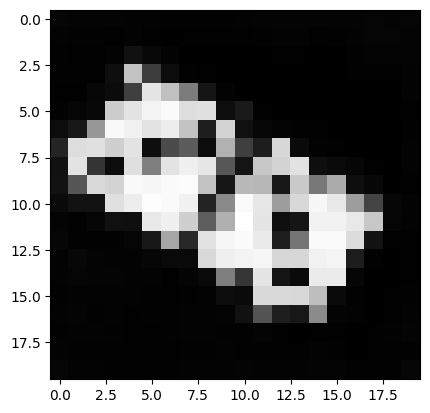

In [ ]:
plt.imshow(test_imgs[0], cmap='gray')
plt.show()

In [ ]:
test_imgs_copy = test_imgs.copy()

tmp_trans = transforms.ToTensor()

test_imgs_t = tmp_trans(test_imgs_copy)

test_mean = torch.mean(test_imgs_t)
test_std = torch.std(test_imgs_t)

print(f'trn mean: {test_mean}')
print(f'trn std: {test_std}')

trn mean: 0.22883383929729462
trn std: 0.3612697124481201


In [ ]:
def testTransformer(img):
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(( 0.22883), (0.36127))
    ])

    img_t = trans(img)

    return img_t

In [ ]:
# Testデータ用のDataset
class TestDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = testTransformer(img)

        return img_t

In [ ]:
BATCH_SIZE = 128
test_ds = TestDataset(imgs=test_imgs)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = ResNet50Wrapper()
model.load_state_dict(torch.load('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/models/resnet50_10M_1/E13_2023-11-03_10-44.pt'))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 53.8MB/s]


ResNet50Wrapper(
  (resnet50): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

In [ ]:
torch.cuda.empty_cache()

In [ ]:
pred_label = torch.zeros(len(test_ds), dtype=torch.long)
model.eval()

for iter_num, X in tqdm(enumerate(test_dl), total=len(test_dl)):

    X = X.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        y_pred, y_softmax = model(X)
        _, label = torch.max(y_softmax, dim=1)
        pred_label[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE] = label.detach() + 1

100%|██████████| 195/195 [00:18<00:00, 10.70it/s]


In [ ]:
pred_label = pred_label.numpy()
pred_label

array([ 6,  8,  8, ...,  5, 11,  3])

In [ ]:
# np.save('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/data/resnet50_E12_data-10M_each-14429.npy', pred_label)

In [ ]:
# import numpy as np
# test_imgs = np.load('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/data/X_test_denoised_by_UNet.npy')
# pred_label = np.load('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/data/resnet50_E12_data-10M_each-14429.npy')

##### 可視化

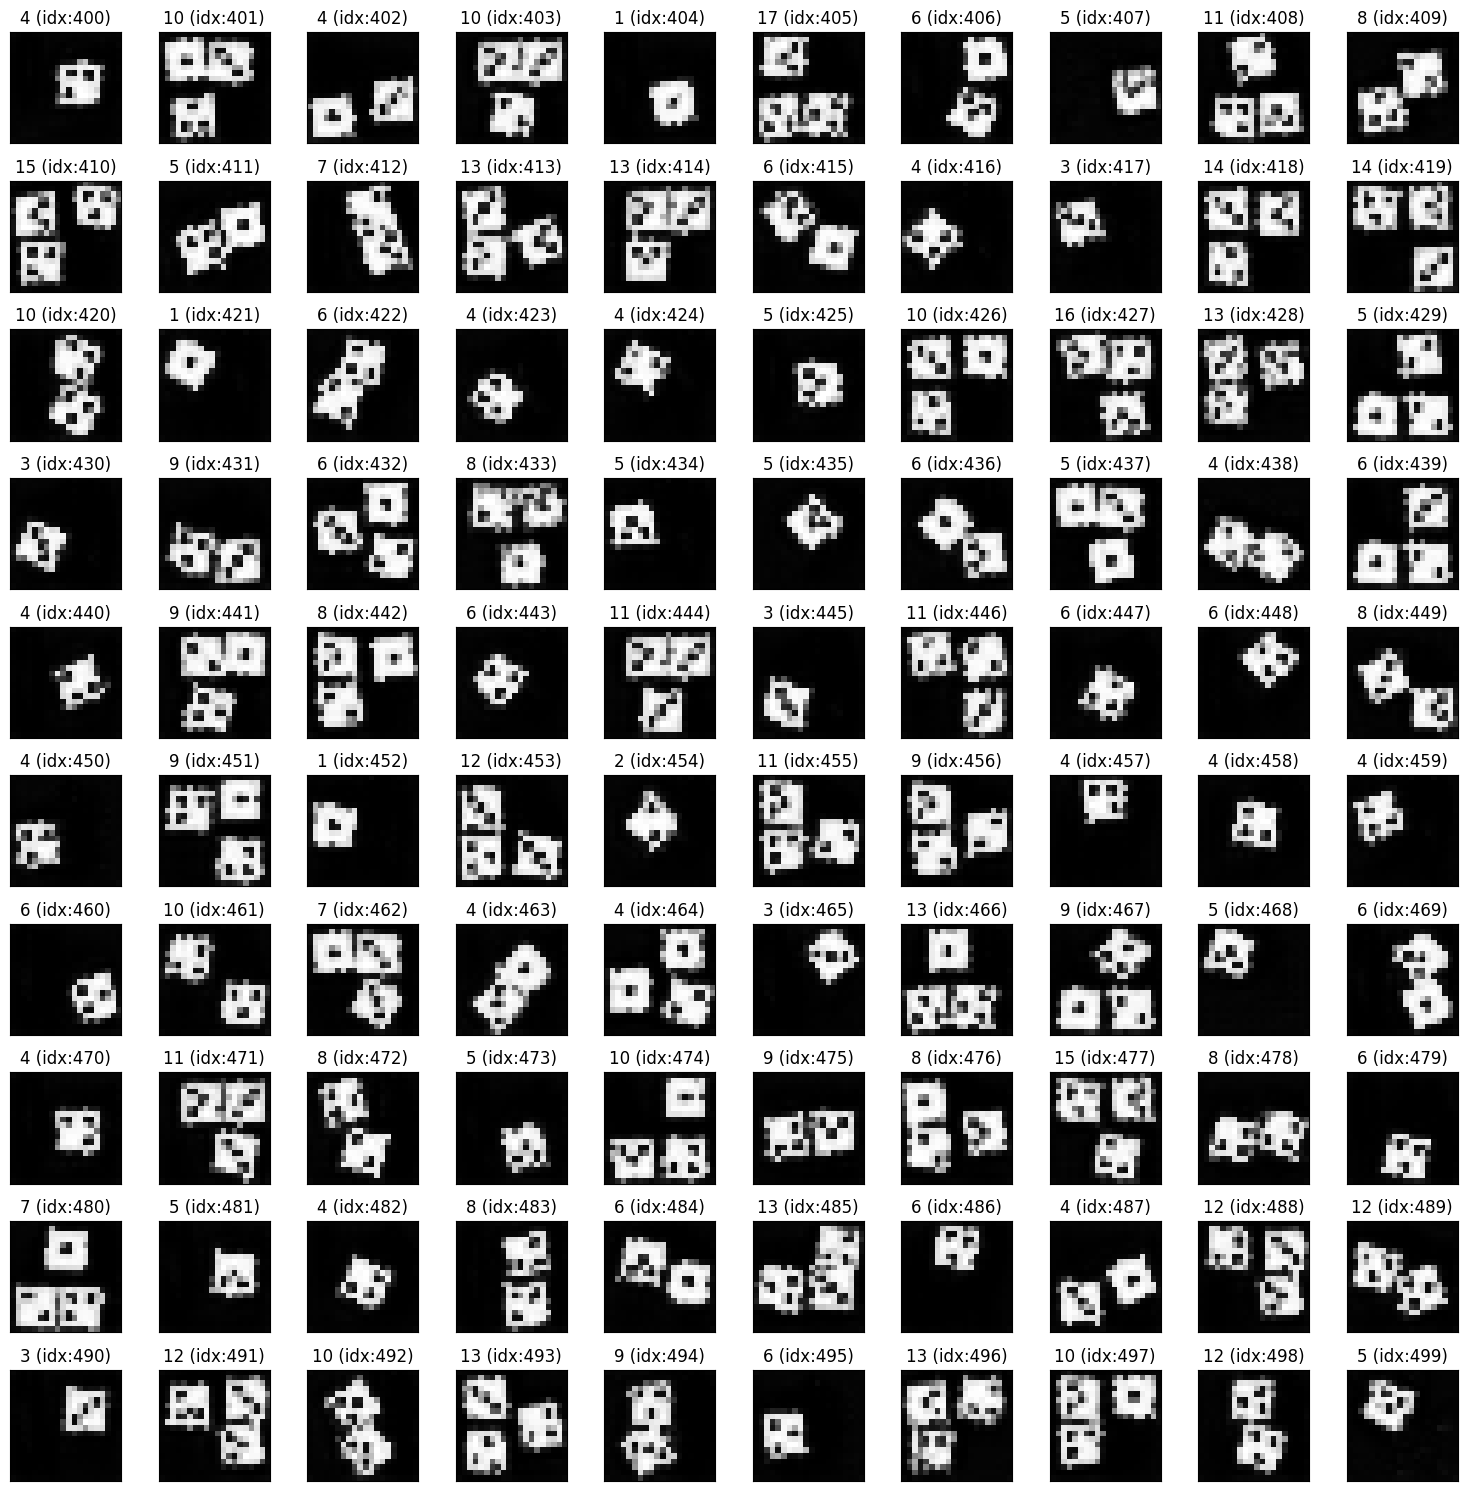

In [ ]:
import matplotlib.pyplot as plt

n = 100
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for i in range(n):
    idx = i + 400
    ax = fig.add_subplot(n//10+1, 10, i+1)
    plt.imshow(test_imgs[idx], cmap='gray')
    plt.title(f'{pred_label[idx]} (idx:{idx})')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

In [ ]:
X_test = np.load('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/data/X_test.npy')

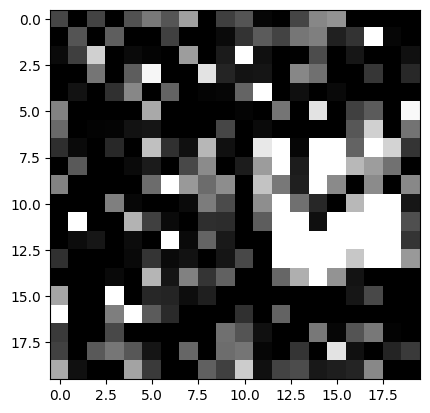

In [ ]:
plt.imshow(X_test[407].reshape(20, 20), cmap='gray')

##### 提出ファイルの作成

In [ ]:
submit_df = pd.read_csv('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/data/sample_submit.csv', header=None)

In [ ]:
submit_df[1] = pred_label

In [ ]:
submit_df

,0,1
0,0,6
1,1,8
2,2,8
3,3,7
4,4,6
...,...,...
24917,24917,11
24918,24918,7
24919,24919,5
24920,24920,11


In [ ]:
# submit_df.to_csv('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/work/resnet50_E15_data-10M_each-14429.csv', header=False, index=False)
# submit_df.to_csv('/content/drive/MyDrive/MyStudy/MySIGNATE/SonyDice/work/resnet50_E13_data-10M_each-14429.csv', header=False, index=False)

In [1]:
import torch

In [21]:
a = torch.tensor([1])
a.to('cpu')
a

tensor([1])

In [24]:
a.to('cpu').detach().item()

AttributeError: 'int' object has no attribute 'copy'